In [30]:
import sys
sys.path.append('../../')

import numpy as np
from qiskit import IBMQ, Aer
import matplotlib.pyplot as plt
from main import device_process_measurement_tomography, Quantities, Cross_Quantities,DiamondNorm
from qiskit.compiler import transpile
from qiskit.providers.ibmq.managed import IBMQJobManager
from utils_qiskit import *

In [7]:
IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='csic-1', project='main')
backend = provider.get_backend('ibm_perth')
simulator = Aer.get_backend('aer_simulator')
job_manager = IBMQJobManager()

ibmqfactory.load_account:WARNING:2022-11-02 12:41:21,463: Credentials are already in use. The existing account in the session will be replaced.


In [8]:
parall_qubits = [ [ (0,1), (3,5) ],
                    [ (0,1) ],
                    [ (3,5) ]
                ]

qndmt = device_process_measurement_tomography( backend, parall_qubits=parall_qubits )
circuits_qndmt = qndmt.circuits()

In [9]:
job_ids = [
    '7364c64cb08643c8b7a331db8760be76-16638006144369087',
'a317d2f4d40e4138a90e3d867f81aead-16638008680736837',
'5561e4224aee40b3b5b4589851fa1ade-16638008773492372',
'798207b0a1b44a32b79cc4dc3ee95aec-16638008859225643',
'f548a504154e412c8b8def1e60e8e5a7-16638008944027708'
]

In [10]:
results_tomo = []

for job_str in job_ids:
    job = job_manager.retrieve_job_set( job_str, provider )
    result_qiskit = job.results().combine_results()
    save_results( result_qiskit, name = job_str)     
    result_tomo  = qndmt.fit( result_qiskit, paralell=True, gate_set=True ) 
    results_tomo.append( result_tomo )

In [43]:
np.save( 'results_tomo', np.array(results_tomo, dtype=object) )

In [11]:
quantities_2_mc = []
cros_quantities_mc = []

for k in range(5):

    choi_single = results_tomo[k].single.chois
    povm_single = results_tomo[k].single.povms
    choi_double = [ results_tomo[k].double[j].chois for j in range(3) ]
    povm_double = [ results_tomo[k].double[j].povms for j in range(3) ]

    quantities_2 = []
    cros_quantities = []
    for i in range(len(parall_qubits)):
        for j in range(len(parall_qubits[i])):
            k = parall_qubits[i][j][0]
            l = parall_qubits[i][j][1]
            cros_quantities.append( Cross_Quantities( povm_single[k], choi_single[k],
                                                    povm_single[l], choi_single[l],
                                                    povm_double[i][j], choi_double[i][j]
                                                    )  )
            quantities_2.append( Quantities( povm_double[i][j], choi_double[i][j] ) )

    quantities_2_mc.append( quantities_2 )
    cros_quantities_mc.append( cros_quantities )

In [36]:
def diamond_norms_fun( chois_in, chois_pa ):

    F = ( DiamondNorm( chois_in[0] - chois_pa[0], 'vec'  )
        + DiamondNorm( chois_in[1] -  chois_pa[1], 'vec'  ) 
        + DiamondNorm( chois_in[2] -  chois_pa[2], 'vec'  ) 
        + DiamondNorm( chois_in[3] -  chois_pa[3], 'vec'  ) 
        ) / 4
        
    return F

In [40]:
diamond_norms = []
for k in range(5):
    choi_double = [ results_tomo[k].double[j].chois for j in range(3) ]
    diamond_norms.append(  [ diamond_norms_fun(choi_double[0][0],choi_double[1][0]),
                    diamond_norms_fun(choi_double[0][1],choi_double[2][0])] )

diamond_norms_mean = np.mean( diamond_norms,0 )
diamond_norms_std  = np.std( diamond_norms,0 )  

In [12]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size"  : 22,
    "font.sans-serif": ["Helvetica"]})

In [19]:
quantities_2_mc = np.array( quantities_2_mc )
error_mean = abs( np.mean( quantities_2_mc[:,:2,:]- quantities_2_mc[:,2:,:], 0 ) )
error_std = abs( np.std( quantities_2_mc[:,:2,:]- quantities_2_mc[:,2:,:], 0 ) )

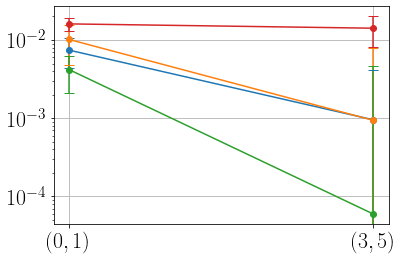

In [42]:
for j in range(3):
    plt.errorbar( [0,1], error_mean[:,j], yerr=error_std[:,j], fmt='-o', capsize=5 )
plt.errorbar( [0,1], diamond_norms_mean, yerr=diamond_norms_std, fmt='-o', capsize=5 )
plt.xticks( [0,1], labels=[ '$(0,1)$', '$(3,5)$' ]   )
plt.grid()
plt.yscale('log')


In [45]:
error_mean

array([[7.42011776e-03, 1.01592062e-02, 4.18739850e-03],
       [9.54049387e-04, 9.38843637e-04, 5.96179307e-05]])

In [46]:
error_std

array([[0.00309928, 0.0053046 , 0.00206848],
       [0.0032122 , 0.00685577, 0.00465332]])

In [47]:
diamond_norms_mean

array([0.01605136, 0.01413639])

In [48]:
diamond_norms_std

array([0.00294134, 0.00589483])